In [1]:
from collections import defaultdict
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import gc

# Global Variables

In [2]:
timeout = 10 ** 5
threshold = 0.001

# State Spaces

In [3]:
class StateSpace:
    def __init__(self, start):
        self.start = start
        
    def actions(self, state):
        raise NotImplementedError
        
    def rewards(self, state, action, next_state, time):
        raise NotImplementedError
    
    def next_state(self, state, action, time):
        raise NotImplementedError
    
    def transition(self, state, action, time):
        next_state = self.next_state(state, action, time)
        return self.rewards(state, action, next_state, time), next_state

## Gridworlds

In [19]:
directions = {
    "u": ( 1, 0),
    "d": (-1, 0),
    "r": (0,  1),
    "l": (0, -1)
}

class GridWorld(StateSpace):
    def __init__(self, start = (0, 0), edges = 25, density = 5):
        super().__init__(start)
        self.edges = edges
        self.density = density
        self.validate = self.edges ** 4
        
    def actions(self, state):
        return [ "u", "d", "r", "l" ]
        
    def rewards(self, state, action, next_state, time):
        x, y = next_state
        return (x + y) / 2 if (x + y) % 10 < self.density else 0
    
    def next_state(self, state, action, time):
        return tuple(map( lambda x, y: (x + y) % self.edges, state, directions[action] ))

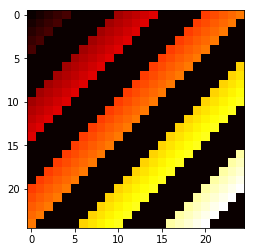

In [20]:
heatmap = [[ (x + y) / 2 if (x + y) % 10 < 5 else 0 for x in range(25) ] for y in range(25) ]

plt.imshow( heatmap, cmap = "hot" )
plt.show()

In [34]:
def linear(x, y, time, regime):
    return regime, time

def independent(x, y, time, regime):
    return regime, abs(x - y) * time * 0.00001

def n_state(n, M, Q):
    def dynamics(x, y, time, regime):
        d = np.eye(1, n, regime)
        next_state = np.random.choice(n, p = d.dot(M))
        return next_state, Q[next_state]
    return dynamics

class NonStationary(GridWorld):
    def __init__(self, start = (0, 0), edges = 25, density = 2, dynamic = linear):
        self.regime, self.dynamics = 0, dynamic
        super().__init__(start, edges, density)
        
    def rewards(self, state, action, next_state, time):
        self.regime, trend = self.dynamics(* state, time, self.regime)
        return super().rewards(state, action, next_state, time) + trend

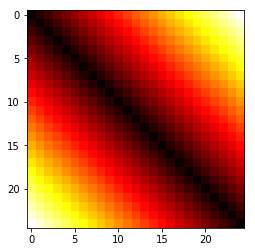

In [7]:
heatmap = [[ abs(x - y) for x in range(25) ] for y in range(25) ]

plt.imshow( heatmap, cmap = "hot" )
plt.show()

## N-Armed Bandit

In [8]:
class BanditTask(StateSpace):
    def __init__(self, start = 0, correct = 0, n = 2):
        super().__init__(start)
        
        self.correct = 0
        self.switch  = np.random.randint(7, 24)
        self.N = n
        self.validate = (n * 24) ** 2
        
    def actions(self, state):
        return list( range(self.N) )
        
    def rewards(self, state, action, next_state, time):
        return 1 * (action == self.correct)
    
    def next_state(self, state, action, time):
        self.switch = self.switch - 1
        if self.switch == 0:
            self.correct = np.random.randint( self.N )
            self.switch  = np.random.randint(7, 24)
        return state

# Agents

In [9]:
class agent:
    def __init__( self, action_selection = None, alpha = 0.1, discount = 0.1, epsilon = 0.5 ):
        self.q_vals, self.v_vals = defaultdict(lambda: 0), defaultdict(lambda: 0)
        
        self.alpha, self.epsilon, self.discount = alpha, epsilon, discount
        if action_selection:
            self.action_selection = action_selection
 
    def max_action(self, state, time):
        return max(self.space.actions(state), key = lambda x: self.q_value(state, x, time))

    def action_selection(self, state, time):
        return self.max_action(state, time)
    
    def q_value(self, state, action, time):
        return self.q_vals[(state, action)]
    
    def update(self, state, next_state, action, reward, time):        
        max_q_val  = self.q_vals[( next_state, self.max_action(state, time) )]
        previous = self.q_vals[(state, action)]
        
        self.q_vals[(state, action)] = (1 - self.alpha) * previous + self.alpha * (reward + self.discount * (max_q_val))
        self.v_vals[state] = self.v_vals[state] + 1
        
        delta = self.q_vals[(state, action)] - previous
        return delta
        
    def play(self, space):  
        time, state = 0, space.start
        self.space = space
        
        TDEs = []
        while (self.alpha > 0.01) and (time < timeout):
            action = self.action_selection(self, state, time)
            reward, next_state = self.space.transition(state, action, time)

            delta = self.update(state, next_state, action, reward, time)
            TDEs.append( abs(delta) )
            
            self.alpha = ( self.alpha * 0.999 ) if abs(delta) < threshold else min( self.alpha * 1.001, 1.0 )
            state, time = next_state, time + 1
            
        return self.validate(), time, TDEs
    
    def validate(self):
        average_reward, state = 0, self.space.start
        for p in range( self.space.validate ):
            reward, state = self.space.transition(state, self.max_action(state, p), p)
            average_reward = average_reward + reward 
        return average_reward / p

In [10]:
class linear_agent(agent): 
    def __init__( self, action_selection = None, alpha = 0.1, discount = 0.1, epsilon = 0.5 ):
        super().__init__(action_selection, alpha, discount, epsilon)
        self.xis, self.last = defaultdict(lambda: 0), defaultdict(lambda: (0,0))
     
    def update_xi(self, state, action, reward, time):
        previous, timestamp = self.last[(state, action)]
        
        if self.v_vals[state] > 0:
            change = (reward - previous) / (time - timestamp)
            self.xis[(state, action)] = (self.alpha * change) + (1 - self.alpha) * self.xis[(state, action)]
        
        self.last[(state, action)] = (reward, time)
        return reward - ( self.xis[(state, action)] * time )
    
    def q_value(self, state, action, time):
        return super().q_value(state, action, time) + self.xis[(state, action)] * time
    
    def update(self, state, next_state, action, reward, time):
        reward = self.update_xi(state, action, reward, time)
        return super().update(state, next_state, action, reward, time)

In [11]:
def epsilon_greedy(self, state, time, epsilon = None):
    max_action = max(self.space.actions(state), key = lambda x: self.q_value(state, x, time))
    return max_action if np.random.random() < (epsilon or self.epsilon) else np.random.choice( self.space.actions(state) )

def softmax(self, state, time, beta = 1):
    q_vals = np.array([ self.q_value(state, a, time) for a in self.space.actions(state) ])
    q_vals = q_vals - max(q_vals)
    
    softmax = np.exp((q_vals * beta)) / ( np.sum(np.exp(q_vals * beta)) )
    return np.random.choice( self.space.actions(state), p = softmax )

def boltzmann(self, state, time, epsilon = None):
    return softmax(self, state, time, (epsilon or self.epsilon))
    
def mixture(self, state, time, epsilon = None):
    return softmax(self, state, time) if np.random.random() < (epsilon or self.epsilon) else np.random.choice( self.space.actions(state) )

action_selection_strategies = { "Epsilon-Greedy": epsilon_greedy, "Boltzmann": boltzmann, "Mixture Model": mixture }

# Trials

In [12]:
def plot_convergence(space, _agent = agent, plot_title = ""):
    for title, strategy in action_selection_strategies.items():
        r, i, t = _agent( strategy ).play( space )
        
        plt.plot( range(i), t, label = title + " -- E[R]: " + str(round(r, 3)) )
        plt.legend()
        
    plt.title( plot_title )
    plt.show()

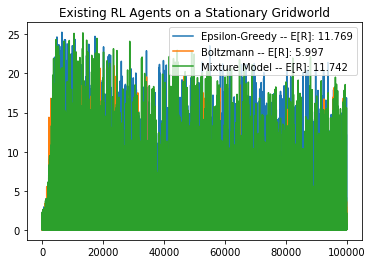

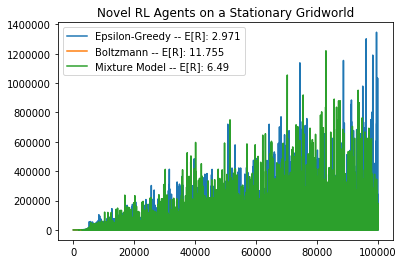

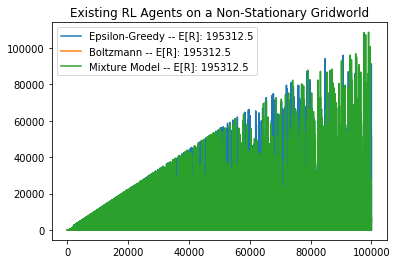

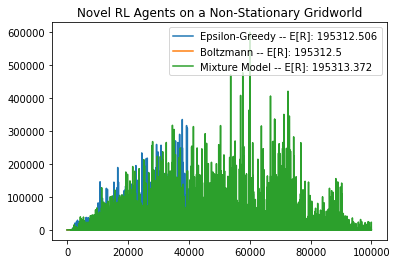

In [13]:
plot_convergence( GridWorld(), plot_title = "Existing RL Agents on a Stationary Gridworld" )
plot_convergence( GridWorld(), _agent = linear_agent, plot_title = "Novel RL Agents on a Stationary Gridworld" )

plot_convergence( NonStationary(), plot_title = "Existing RL Agents on a Non-Stationary Gridworld")
plot_convergence( NonStationary(), _agent = linear_agent, plot_title = "Novel RL Agents on a Non-Stationary Gridworld" )

## P-Values of the Novel Agent(s)

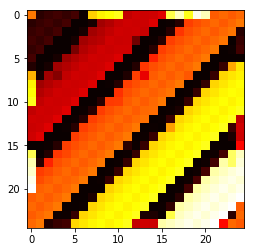

In [29]:
_agent = linear_agent( epsilon_greedy )
_agent.play( GridWorld() )


q_values = [[ _agent.q_value( (x, y), _agent.max_action((x, y), 0), 0 ) for x in range(25) ] for y in range(25) ]
plt.imshow( q_values, cmap = "hot")
plt.show()

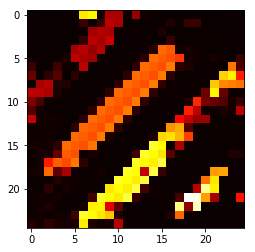

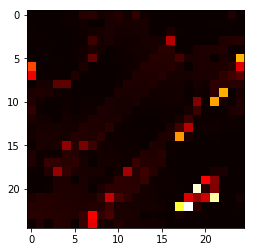

In [35]:
_agent = linear_agent( epsilon_greedy )
_agent.play( NonStationary( dynamic = independent ) )

q_values = [[ _agent.q_value( (x, y), _agent.max_action((x, y), 0), 0 ) for x in range(25) ] for y in range(25) ]
plt.imshow( q_values, cmap = "hot")
plt.show()

q_values = [[ _agent.q_value( (x, y), _agent.max_action((x, y), 100000), 100000 ) for x in range(25) ] for y in range(25) ]
plt.imshow( q_values, cmap = "hot")
plt.show()

In [ ]:
def sigmoid(x, rho = 1):
    return (np.exp(rho * x) / (1 + np.exp(rho * x)))

plt.plot( range(-11, 11), [ sigmoid(i) for i in range(-11, 11) ] )
plt.show()

In [ ]:
class inhomogenous_agent(agent):
    def __init__( self, action_selection = None, alpha = 0.1, discount = 0.1, rhos = (1, 1), lags = -1 ):
        super().__init__( action_selection, alpha, discount )

        self.rho1, self.rho2 = rhos
        self.TDES, self.L = [], lags
            
    def action_selection(self, state, randomness = None):
        return super().action_selection(state, self.distribution(state))
    
    def update(self, state, next_state, action, reward, time):
        delta = super().update( state, next_state, action, reward, time )
        self.TDES.append(delta)
        
        if self.L > -1 and len(self.TDES) > self.L:
            self.TDES.pop(0)
        return delta
    
    def phi_explore(self, state):
        state_len = len(self.q_vals) + 1
        state_sum = np.sum([ self.v_vals[i] for i in self.v_vals ]) + 1
        return sigmoid((1 / state_len) - ( self.v_vals[state] / state_sum ), self.rho1)
    
    def phi_exploit(self, state):
        relative = self.TDES[-1] / np.sum(self.TDES)
        return sigmoid(1 - (relative * len(self.TDES)), self.rho2)

    def distribution(self, state):
        epsilon = self.phi_exploit(state)
        return epsilon / (epsilon + self.phi_explore(state))

In [ ]:
_agent = inhomogenous_agent( mixture )
r, i, t = _agent.play( space )

print(r, i)
difference = [ (min(* state) / (max(* state) + 1)) - _agent.xis[(state, action)] for state, action in _agent.xis ]
print( np.sqrt( np.mean( np.array(difference) ** 2 ) ) )

plt.plot(range(i), t)
plt.show()

In [ ]:
difference = [ (1 - _agent.xis[(state, action)]) / ((min(* state) + 1) / (max(* state) + 1)) for state, action in _agent.xis ]
np.mean( difference )

In [ ]:
from itertools import product
from random import sample

alpha = discount = density = np.arange(0.1, 1, 0.1)
size, density = np.arange(5, 25, 5), np.arange(0.1, 1, 0.1)

parameters = list( product(alpha, discount, size, density) )
parameters = sample( parameters, len(parameters) // 10 )

In [ ]:
from tqdm import tqdm
import ray

@ray.remote
def run_scenario(strategy, parameter_set, inhomogenous):
    size, density = parameter_set.pop(2), parameter_set.pop(2)
    current_grid = Grid(size, reward_func = density_xor(density))
    
    current_agent = inhomogenous_agent(strategy, *parameter_set) if inhomogenous else agent(strategy, *parameter_set)
    rewards, iterations = current_agent.play( current_grid )
    return [ rewards, iterations ]
    
def test_agent(strategy, inhomogenous = False):
    agent_parameters = product( np.arange(0, 10, 0.5), np.arange(0, 10, 0.5), range(-1, 10) ) if inhomogenous else product( np.arange(0.1, 1, 0.1) )
    total_parameters = [ [*a, *b] for a, b in product( parameters, agent_parameters ) ]
    
    scenario = lambda x: run_scenario.remote(strategy, x, inhomogenous)
    results  = [ scenario(x) for x in tqdm(total_parameters) ]
    results  = ray.get( results )
    
    exogenous  = np.array( total_parameters, dtype = np.float32 )
    endogenous = np.array( results, dtype = np.float32 )

    endo_filename = descriptor + 'inhomogenous_endo.npy' if inhomogenous else '_endo.npy'
    exog_filename = descriptor + 'inhomogenous_exog.npy' if inhomogenous else '_exog.npy'

    np.save(endo_filename, endogenous)
    np.save(exog_filename, exogenous)
    
    gc.collect()

In [ ]:
ray.init()

for strategy in action_selection_strategies:
    test_agent(strategy, pool)
    test_agent(strategy, pool, True)

In [ ]:
import numpy
B = numpy.arange(0.025, 0.2525, 0.025)
[ a for a in B  ]
B

In [ ]:
def B(d1, d2):
    assert len(d1) == len(d2)
    return sum([ np.sqrt(d1[i] * d2[i]) for i in range(len(d1)) ])

def KL(d1, d2):
    assert len(d1) == len(d2)
    return sum([ d1[i] * np.log( d1[i] / d2[i] ) for i in range(len(d1)) ])

def normalize(d):
    d = d + abs(min(d))
    return [ i / sum(d) for i in d ]

def RMSE_q_values(agent, state):
    q_values = [ agent.q_vals[( state, a)] for a in agent.grid.actions(state) ]
    
    next_state = [ agent.grid.transition(state, a)[1] for a in agent.grid.actions(state) ]
    true_rwrds = [ ((x * y) + (x - 25)) / 25 for x, y in next_state ]
    
    return np.linalg.norm(np.array(q_values) - np.array(true_rwrds))

def RMSE_total(agent):
    return np.sqrt(np.mean([ RMSE_q_values(agent, (i, j)) for i in range(agent.grid.edge) for j in range(agent.grid.edge) ]))

In [ ]:
X, Y, Z, T = [], [], [], []

N = 1000
f = B #KL

for epsilon in tqdm(range(1, 11)):
    beta = epsilon / 10
    a, b, c = 0, 0, 0
    
    for i in range(N):
        rand_vec = np.random.random( 25 * 25 )
    
        boltz = np.exp(rand_vec * beta)/np.sum(np.exp(rand_vec * beta))
        mixy  = (1 - beta) *  np.exp(rand_vec)/np.sum(np.exp(rand_vec)) + (beta) * 1 / (rand_vec.shape[0])
        greed = (1 - beta) * (rand_vec == max(rand_vec)).astype("int")  + (beta) * 1 / (rand_vec.shape[0])
        
        a = a + f(boltz, mixy)
        b = b + f(boltz, greed)
        c = c + f(mixy, greed)

    X += [(10 - epsilon) / 10]
    Y += [a / N]
    Z += [b / N]
    T += [c / N]

plt.plot(X, Y, "g")
plt.plot(X, Z, "r")
plt.plot(X, T, "b")
plt.show()

In [ ]:
np.random.seed(0)

def example_matrix(size):
    M = np.random.randint(0, 10, (size, size))
    M = M / M.sum(axis = 1)[:, np.newaxis]
    return M

def random_matrix(size):
    M = np.random.normal(size = (size, size))
    M = M / np.linalg.norm(M)
    return M

M = example_matrix(4)
M

In [ ]:
TRIALS = 200000

data = [ (np.eye(1, 4, np.random.choice(4))[0], np.random.randint(10)) for i in tqdm(range(TRIALS)) ]

result = [ d.dot(np.linalg.matrix_power(M, t)) for d, t in data ]
result = [ np.eye(1, 4, np.random.choice(4, p = r)) for r in result ]

In [ ]:
def update(M, start, end, turns, alpha):
    likelihood = lambda m: end.dot( start.dot( m ** turns ) )
    
    
    return max(matrices, key = likelihood)

In [ ]:
T = np.eye(4)
distance = 1.5

distances = []
for i in tqdm(range(TRIALS)):
    T = update(T, data[i][0], result[i], data[i][1], 0.01)
    distances.append( np.linalg.norm(T - M) )
    
plt.plot( range(TRIALS), distances )
plt.show()

T, M

In [ ]:
a = np.random.normal(size = 10)
b = a / np.linalg.norm(a)

np.linalg.norm(0.11115 * b)